In [21]:
# CELL 1 — Imports and unzip Adult Income dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.style.use("seaborn-v0_8")

# Path to your ZIP file
zip_path = Path(r"C:\Users\VAIBHAB\adult.zip")

if not zip_path.exists():
    raise FileNotFoundError(f"Could not find adult.zip at {zip_path}")

extract_dir = Path("./adult_data")
extract_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

print("Extracted files to:", extract_dir)
print("Contents:", list(f.name for f in extract_dir.iterdir()))


Extracted files to: adult_data
Contents: ['adult.data', 'adult.names', 'adult.test', 'Index', 'old.adult.names']


In [22]:
# CELL 2 — Load adult.data and adult.test into DataFrames

cols = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country",
    "income"
]

data_path  = extract_dir / "adult.data"
test_path  = extract_dir / "adult.test"

# adult.data: no header
df_train = pd.read_csv(
    data_path,
    header=None,
    names=cols,
    sep=",",
    skipinitialspace=True
)

# adult.test: first line is header/comment, labels end with a dot
df_test = pd.read_csv(
    test_path,
    header=0,
    names=cols,
    sep=",",
    skipinitialspace=True
)

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)
df_train.head()


Train shape: (32561, 15)
Test shape : (16281, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [23]:
# CELL 3 — Clean data: handle '?', strip label periods, combine

# Strip whitespace from string columns
for df in [df_train, df_test]:
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].str.strip()

# For test labels: remove trailing '.' if present
df_test["income"] = df_test["income"].str.replace(".", "", regex=False).str.strip()

# Replace '?' with NaN and drop rows with missing values
for df in [df_train, df_test]:
    df.replace("?", np.nan, inplace=True)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Combine train+test into one dataset, we'll create our own train/val/test split
df = pd.concat([df_train, df_test], ignore_index=True)
print("Combined shape after cleaning:", df.shape)
df.head()


Combined shape after cleaning: (45222, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [24]:
# CELL 4 — Separate features and target, define numeric and categorical columns

target_col = "income"
y_raw = df[target_col]
X_raw = df.drop(columns=[target_col])

# Define numeric and categorical columns explicitly
numeric_cols = [
    "age", "fnlwgt", "education_num",
    "capital_gain", "capital_loss", "hours_per_week"
]
categorical_cols = [c for c in X_raw.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [25]:
# CELL 5 — One-hot encode categorical features and scale numeric ones

ohe = OneHotEncoder(handle_unknown="ignore")  # we'll call .toarray()
X_cat = ohe.fit_transform(X_raw[categorical_cols]).toarray()

scaler = StandardScaler()
X_num = scaler.fit_transform(X_raw[numeric_cols])

X = np.hstack([X_num, X_cat])

# Encode target: >50K = 1, <=50K = 0
y = (y_raw == ">50K").astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Positive class proportion:", y.mean())


X shape: (45222, 104)
y shape: (45222,)
Positive class proportion: 0.2478439697492371


In [26]:
# CELL 6 — Train / Validation / Test split

# First split: train (70%), temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: val (15%), test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (31655, 104) (31655,)
Val  : (6783, 104) (6783,)
Test : (6784, 104) (6784,)


In [27]:
# CELL 7 — Convert numpy arrays to PyTorch tensors and create DataLoaders

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

input_dim = X_train.shape[1]
print("Input dimension:", input_dim)


Input dimension: 104


In [58]:
# CELL 8 — MLP

class AdultMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.Sigmoid()   # keep this for BCELoss
        )

    def forward(self, x):
        return self.net(x)

model = AdultMLP(input_dim)
print(model)


AdultMLP(
  (net): Sequential(
    (0): Linear(in_features=104, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Linear(in_features=16, out_features=1, bias=True)
    (12): Sigmoid()
  )
)


In [59]:
# CELL 9 — Best optimizer + loss

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0008
)


In [60]:
# CELL 10 — Best training loop

epochs = 50
train_losses = []
val_losses = []

for ep in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t).squeeze()
        val_loss = criterion(val_preds, y_val_t).item()

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    if ep % 5 == 0:
        print(f"Epoch {ep}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 5/50 | Train Loss: 0.3151 | Val Loss: 0.3156
Epoch 10/50 | Train Loss: 0.3089 | Val Loss: 0.3139
Epoch 15/50 | Train Loss: 0.3049 | Val Loss: 0.3157
Epoch 20/50 | Train Loss: 0.2995 | Val Loss: 0.3306
Epoch 25/50 | Train Loss: 0.2978 | Val Loss: 0.3333
Epoch 30/50 | Train Loss: 0.2872 | Val Loss: 0.3242
Epoch 35/50 | Train Loss: 0.2858 | Val Loss: 0.3296
Epoch 40/50 | Train Loss: 0.2813 | Val Loss: 0.3348
Epoch 45/50 | Train Loss: 0.2766 | Val Loss: 0.3302
Epoch 50/50 | Train Loss: 0.2750 | Val Loss: 0.3342


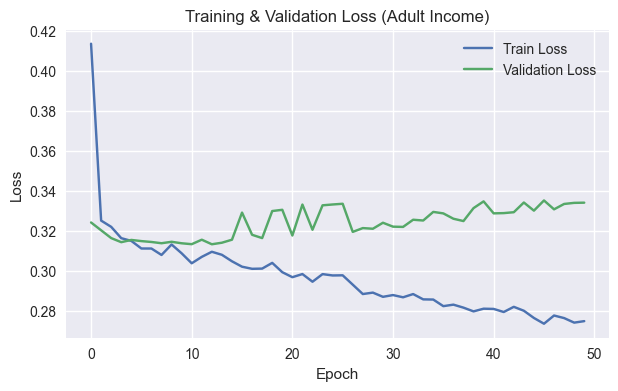

In [61]:
# CELL 11 — Plot training and validation loss curves

plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss (Adult Income)")
plt.legend()
plt.show()


In [62]:
# CELL 12 — Evaluate model on test set

model.eval()
with torch.no_grad():
    probs_test = model(X_test_t).squeeze().cpu().numpy()
    preds_test = (probs_test > 0.5).astype(int)

test_acc = accuracy_score(y_test, preds_test)
print("Test Accuracy:", test_acc)

print("\nClassification Report (Test):")
print(classification_report(y_test, preds_test, digits=4))

cm = confusion_matrix(y_test, preds_test)
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.8481721698113207

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.8646    0.9463    0.9036      5103
           1     0.7715    0.5503    0.6424      1681

    accuracy                         0.8482      6784
   macro avg     0.8181    0.7483    0.7730      6784
weighted avg     0.8416    0.8482    0.8389      6784

Confusion Matrix:
 [[4829  274]
 [ 756  925]]


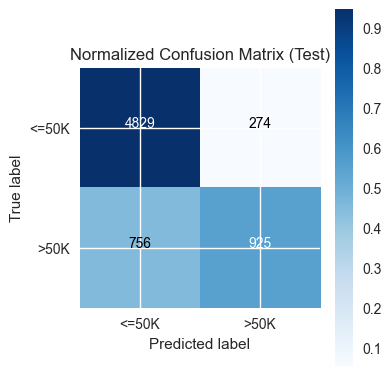

In [63]:
# CELL 13 — Visualize confusion matrix

import itertools

plt.figure(figsize=(4,4))
classes = ["<=50K", ">50K"]
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(j, i, f"{cm[i,j]}",
             horizontalalignment="center",
             color="white" if cm_norm[i,j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
